In [181]:
import os
import numpy as np
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import WMAP9 as cosmo
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import corner
import emcee

## Haremos un ajuste a los datos del archivo jla_lcparams con usando un likelihood Gaussiano y el siguiente modelo:
## $\boxed{\mu = m_B^* - (M_B-\alpha X_1 + \beta C)}$
### Siendo $\alpha, \beta, M_B$ son parámetros nuisance.
### Empezaremos cargando los datos con sus respectivos errores.

In [185]:
data = np.loadtxt('jla_lcparams.txt',usecols=(1,2,3,4,5,6,7,8,9,10,11,12))                                                         
c = 1                                                              #Numero de caminantes
p = 3                                                              #Número de parámetros
om = 0.295

In [186]:
n = len(data)
mu = np.zeros((2,n))
err = np.zeros((3,n))
mb,X1,C = np.zeros(n),np.zeros(n),np.zeros(n)
for i in range(740):
    mb[i],X1[i],C[i] = data[i,3],data[i,5],data[i,7]
    err[0,i],err[1,i],err[2,i] = data[i,4],data[i,6],data[i,8]
    mu[0,i] = data[i,0]
cosmo = FlatLambdaCDM(H0=70, Om0=om, Tcmb0=2.725).luminosity_distance(mu[0])
mu[1] = 5*np.log10(cosmo.value/10e-6)
error = err[0]**2 + err[1]**2 + err[2]**2

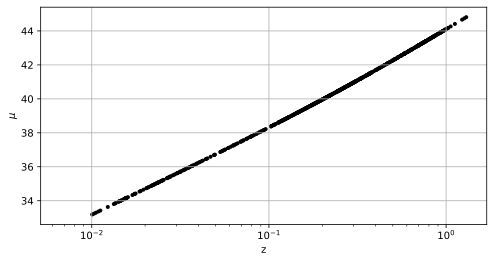

In [232]:
plt.rcParams['figure.figsize'] = (8,4)
#plt.errorbar(mu[0], mu[1], yerr=np.sqrt(error), xerr = 0, fmt='.', color="black")
plt.scatter(mu[0], mu[1], marker='.',color="black")
plt.xscale('log')
plt.xlabel('z')
plt.ylabel('$\mu$')
plt.grid()
plt.show()

In [188]:
def prior(u):
    if 1 < u[0] < 2 and 1 < u[1] < 4 and (-22) < u[2] < (-15):
        pri = -np.log((2-(-1))*(4-(1))*(-15-(-22)))
    else:
        pri = -999999999     #np.NINF
    return pri               

In [189]:
def posterior(w):
    llt = 0
    for i in range (n):
        fx = mb[i] + X1[i]*w[0] - C[i]*w[1] - w[2]                               #w = [alpha,beta,MB]
        llt+= -(1/(2*error[i]))*(mu[1,i]-fx)**2   
    llt += prior(w)
    return llt

In [196]:
pos = [0,2,-18] + 1e-4 * np.random.randn(8, 3)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, posterior)
sampler.run_mcmc(pos, 10000, progress=True);

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [05:41<00:00, 29.25it/s]


In [197]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)    #flat=True
print(flat_samples.shape)

(5280, 3)


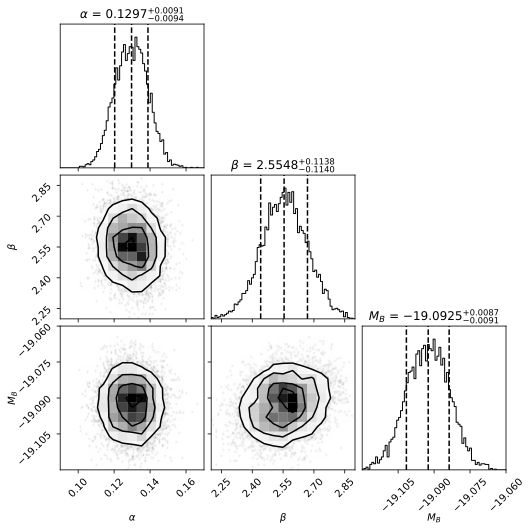

In [233]:
fig = corner.corner(
    flat_samples,
    bins=15,
    hist_bin_factor=5,
    range=[[0.09,0.17],[2.2,2.9],[-19.12,-19.06]],
    labels=[r"$\alpha$", r"$\beta$",r"$M_B$"],
    quantiles=[0.16, 0.5, 0.84],
    #levels=(1-np.exp(-0.5),),
    title_fmt='.4f',
    show_titles=True, title_kwargs={"fontsize": 12}
);

In [228]:
from IPython.display import display, Math
labels = ["a", "b","Mb"]
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [194]:
corner.corner?